# Transfer Learning

Here is to explore how good/bad of pretrained large model such as ResNet on time series data predictions.



## Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, constant, glorot_uniform, identity

tf.random.set_seed(1)
sns.set_style('darkgrid')


2023-07-30 12:04:15.579945: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 12:04:15.603226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 12:04:15.987049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


### Data Engineering

As analyzed before, we will add the following features to dataset:
1. time features: sine and cosine pairs of day, bimonth and year

We will not detrend the target data, as we will use a skip connection to add the detrended data to the model.

In [3]:
# add time features
date_time = df.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# the data has obvious daily pattern, bimonth pattern and annual pattern
day = 24*60*60
bimonth = (365.2425/6)*day
year = (365.2425)*day

# use cos/sin as 0 should be close to 23
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['bimonth_sin'] = np.sin(timestamp_s * (2 * np.pi / bimonth))
df['bimonth_cos'] = np.cos(timestamp_s * (2 * np.pi / bimonth))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))


We will only predict one target variable.

In [4]:

def target_transform(y):
    return np.log(y+50).diff()

def inverse_target_transform(dy, y_start):
    return np.exp(dy.cumsum()+np.log(y_start+50)) - 50

# we set to one target for now
target = target_names[0]
df_cpy = df.copy()

y = df_cpy[target]
df_cpy = df_cpy.drop(columns=target_names)
df_cpy = pd.concat([df_cpy, y], axis=1)

# transform target with given function
y_start = y.iloc[0]
df_cpy[target] = target_transform(y)



## Train/Val/Test split

If we do normal splitting (70%, 15%, 15%), the validation data distribution will be different from training data and testing data, which will be difficult to evaluate if the model is underfitting or just behaving well on the validation data. So we will split the data in a way that the validation data distribution is similar to the training data distribution.

We split the data into 4 parts:
- training data: 70%
- train-val data: 10%
- val data: 10%
- test data: 10%

In [5]:
train_ratio = 0.6
train_val_ratio = 0.1
val_ratio = 0.15
test_ratio = 0.15

n = len(df_cpy)
train_df = df_cpy[0:int(n*train_ratio)]
train_val_df = df_cpy[int(n*train_ratio):int(n*(train_ratio+train_val_ratio))]
val_df = df_cpy[int(n*(train_ratio+train_val_ratio)):int(n*(train_ratio+train_val_ratio+val_ratio))]
test_df = df_cpy[int(n*(train_ratio+train_val_ratio+val_ratio)):]

n_features = len(df_cpy.columns)

# drop the first row of train data as it is NAN due to difference detrending
train_df = train_df.iloc[1:]

<Axes: xlabel='interval_ending_dt_utc'>

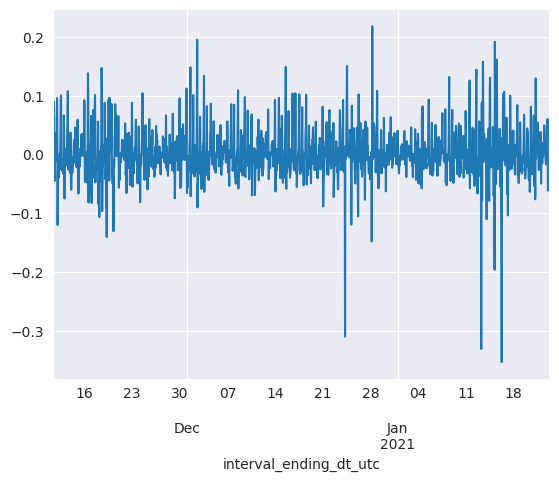

In [6]:
train_val_df[target].plot()

(4.725722835223475e-05, 0.06560733362116213)

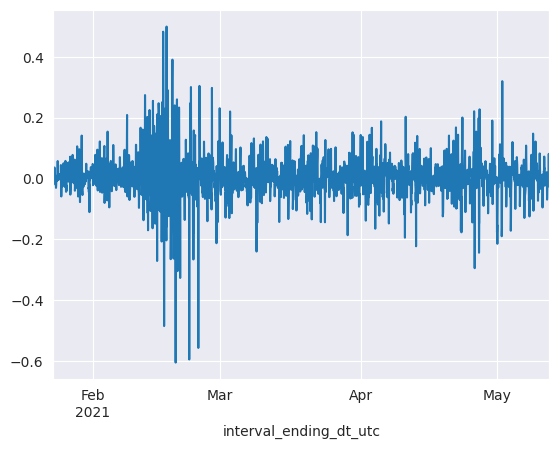

In [7]:
val_df[target].plot()
val_df[target].mean(), val_df[target].std()

(9.134646921215946e-05, 0.04670650460842325)

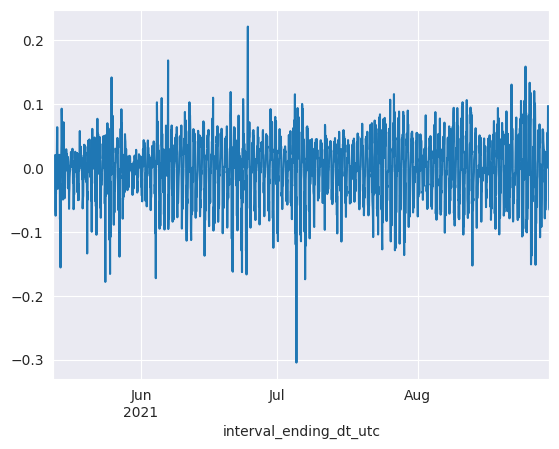

In [8]:
test_df[target].plot()
test_df[target].mean(), test_df[target].std()

## Normalize Data


We see that the data distribution is mismatched

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
train_val_df = (train_val_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print(train_df[target].mean(), train_df[target].std())
print(train_val_df[target].mean(), train_val_df[target].std())
print(val_df[target].mean(), val_df[target].std())
print(test_df[target].mean(), test_df[target].std())

-5.034449459098547e-18 1.0
0.0008927586621849807 1.1231623387831369
0.0015926960945987828 1.8858722362203488
0.0028600342207582593 1.3425709509936785


## Dataset

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size=32, seed=1,
               train_df=train_df, train_val_df = train_val_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.train_val_df = train_val_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size
    self.seed = seed
    
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  # split window method
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def plot(self, model=None, plot_col=None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    
  # make data set method
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        seed = self.seed,
        batch_size=self.batch_size,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def train_val(self):
    return self.make_dataset(self.train_val_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11]
Label column name(s): ['da_energy_aeci_lmpexpost_ac']
All shapes are: (batch, time, features)
Window shape: (3, 12, 45)
Inputs shape: (3, 8, 45)
Labels shape: (3, 4, 1)


2023-07-30 12:04:18.765875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 12:04:18.779733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 12:04:18.779820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

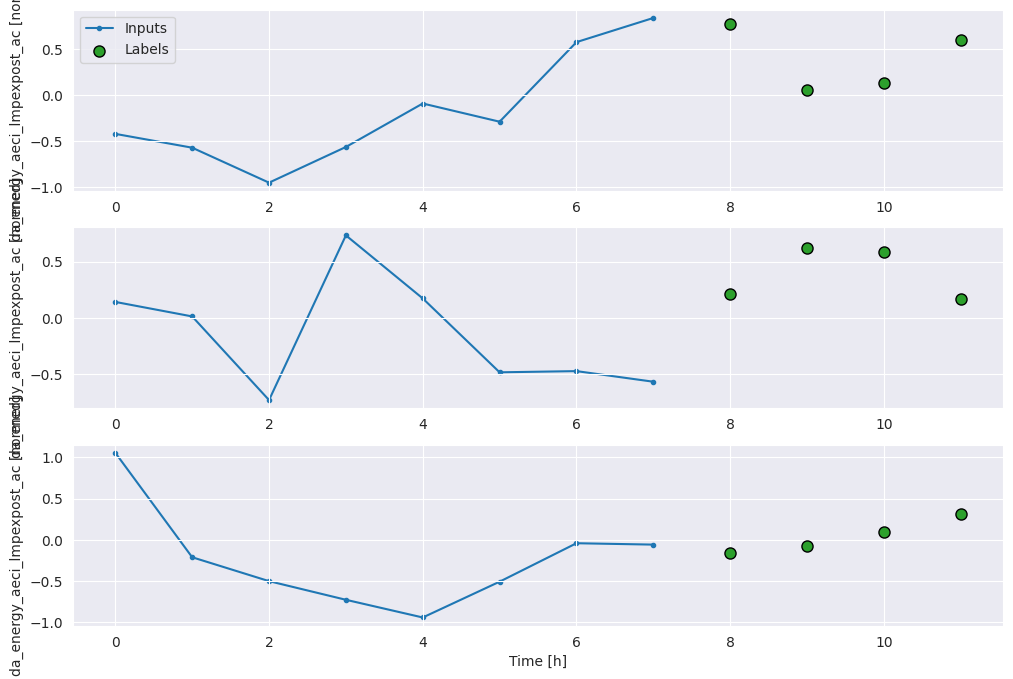

In [11]:
# example: use previous 8 steps to predict next 4 steps
input_width = 8
label_width = 4
shift = 4
example_window = WindowGenerator(
    input_width=input_width, 
    label_width=label_width, 
    shift=shift,
    label_columns=[target])

print(example_window)
batch_window = tf.stack([np.array(train_df[:example_window.total_window_size]),
                           np.array(train_df[100:100+example_window.total_window_size]),
                           np.array(train_df[200:200+example_window.total_window_size])])
batch_inputs, batch_labels = example_window.split_window(batch_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {batch_window.shape}')
print(f'Inputs shape: {batch_inputs.shape}')
print(f'Labels shape: {batch_labels.shape}')

# plot some training data
example_window.plot(plot_col=target)

## Training Functions


In [12]:
def compile_and_fit(model, window, MAX_EPOCHS=50, lr = 1e-04, patience=2):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
  #                                                  patience=patience,
  #                                                  mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.train_val
                      #callbacks=[early_stopping]
                      )
  return history

## Baseline

In [13]:
n_lags = 24
n_outs = 1
shift = 1
window = WindowGenerator(
    input_width=n_lags, 
    label_width=n_outs, 
    shift=shift,
    label_columns=[target])

train_val_performance = {}
val_performance = {}
test_performance = {}

In [14]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])


train_val_performance['Baseline'] = baseline.evaluate(window.train_val, verbose=2)
val_performance['Baseline'] = baseline.evaluate(window.val, verbose=2)   
test_performance['Baseline'] = baseline.evaluate(window.test, verbose=2)

54/54 - 0s - loss: 1.5961 - mean_absolute_error: 0.9131 - 109ms/epoch - 2ms/step


2023-07-30 12:04:19.993368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-30 12:04:19.993553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-30 12:04:20.122935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45]
	 [[{{node

82/82 - 0s - loss: 4.2901 - mean_absolute_error: 1.4122 - 92ms/epoch - 1ms/step
82/82 - 0s - loss: 3.8307 - mean_absolute_error: 1.5129 - 106ms/epoch - 1ms/step


2023-07-30 12:04:20.233036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]
2023-07-30 12:04:20.233222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]


## Conv1D + Skip Connection

In [15]:
def conv1d_net(input_shape, n_outs, initializer=glorot_uniform, seed=0):
    
    X_input = tf.keras.Input(input_shape)
    
    X = tf.keras.layers.Conv1D(filters=3, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X_input)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPool1D(pool_size=3, strides=2)(X)
    # shape of X_shortcut is (None, 8, 32)
    X_shortcut = X   
    
    # a conv1d block
    X = tf.keras.layers.Conv1D(filters=32, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(filters=32, kernel_size=(3,), strides=1, padding='same', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(filters=128, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    
    # conv for shortcut
    X_shortcut = tf.keras.layers.Conv1D(filters=128, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut, training=True)
    
    # add a skip connection
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    # add a fully conenction network
    X = tf.keras.layers.Flatten()(X)
    #X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dense(n_outs)(X)
    #X = tf.keras.layers.Activation('relu')(X)

    # compile model
    model = tf.keras.Model(
        inputs = X_input, 
        outputs = X, 
        name = 'conv1d_net')

    return model
    
    

In [16]:
conv1d = conv1d_net(input_shape=(n_lags, n_features), n_outs=1)
conv1d.summary()

Model: "conv1d_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 45)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 3)        138         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 3)       12          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 24, 3)        0           ['batch_normalization[0]

Epoch 1/50


2023-07-30 12:04:20.683527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [10473]
	 [[{{node Placeholder/_8}}]]
2023-07-30 12:04:20.683729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10497,45]
	 [[{{node Placeholder/_0}}]]
2023-07-30 12:04:22.162385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-30 12:04:22.596509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-

328/328 [==============================] - ETA: 0s - loss: 1.0107 - mean_absolute_error: 0.6839

2023-07-30 12:04:29.090743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-30 12:04:29.090935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]


328/328 [==============================] - 9s 16ms/step - loss: 1.0107 - mean_absolute_error: 0.6839 - val_loss: 1.3017 - val_mean_absolute_error: 0.7688
Epoch 2/50
328/328 [==============================] - 5s 15ms/step - loss: 0.9459 - mean_absolute_error: 0.6543 - val_loss: 1.3258 - val_mean_absolute_error: 0.7844
Epoch 3/50
328/328 [==============================] - 5s 15ms/step - loss: 0.9286 - mean_absolute_error: 0.6469 - val_loss: 1.3109 - val_mean_absolute_error: 0.7802
Epoch 4/50
328/328 [==============================] - 5s 15ms/step - loss: 0.9178 - mean_absolute_error: 0.6426 - val_loss: 1.3036 - val_mean_absolute_error: 0.7779
Epoch 5/50
328/328 [==============================] - 5s 16ms/step - loss: 0.9030 - mean_absolute_error: 0.6361 - val_loss: 1.2865 - val_mean_absolute_error: 0.7699
Epoch 6/50
328/328 [==============================] - 5s 16ms/step - loss: 0.8939 - mean_absolute_error: 0.6334 - val_loss: 1.2621 - val_mean_absolute_error: 0.7654
Epoch 7/50
328/328 [=

2023-07-30 12:08:30.837711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-30 12:08:30.837899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-30 12:08:31.049177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45

82/82 - 0s - loss: 3.2763 - mean_absolute_error: 1.1241 - 425ms/epoch - 5ms/step
82/82 - 0s - loss: 1.6120 - mean_absolute_error: 0.9687 - 139ms/epoch - 2ms/step


2023-07-30 12:08:31.494251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45]
	 [[{{node Placeholder/_0}}]]
2023-07-30 12:08:31.494436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


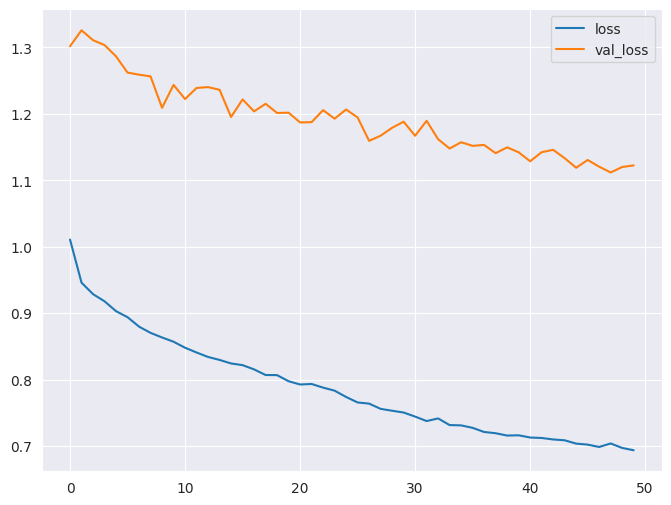

In [17]:
history = compile_and_fit(conv1d, window, MAX_EPOCHS=50)

print("==================================================")
train_val_performance['Conv1d'] = conv1d.evaluate(window.train_val, verbose=2)
val_performance['Conv1d'] = conv1d.evaluate(window.val, verbose=2)
test_performance['Conv1d'] = conv1d.evaluate(window.test, verbose=2)

# plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [18]:
# get the weights from the trained model

for layer in conv1d.layers:
    weights = layer.get_weights()
    if len(weights)==2:
        w, b = weights
        print(layer.name, w.shape, b.shape)
    elif len(weights)==1:
        w = weights[0]
        print(layer.name, w.shape)

conv1d (1, 45, 3) (3,)
conv1d_1 (7, 3, 32) (32,)
conv1d_2 (1, 32, 32) (32,)
conv1d_3 (3, 32, 32) (32,)
conv1d_4 (1, 32, 128) (128,)
conv1d_5 (1, 32, 128) (128,)
dense (1024, 1) (1,)


## LSTM 

In [21]:
lstm_lags = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=n_outs), #activation='relu'),
])

# check model summary
input_shape=(32, n_lags, n_features)
lstm_lags.build(input_shape)
lstm_lags.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (32, 128)                 89088     
                                                                 
 dropout_1 (Dropout)         (32, 128)                 0         
                                                                 
 dense_2 (Dense)             (32, 1)                   129       
                                                                 
Total params: 89,217
Trainable params: 89,217
Non-trainable params: 0
_________________________________________________________________


2023-07-30 12:09:53.143639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 12:09:53.144297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 12:09:53.144752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-07-30 12:09:56.251932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-30 12:09:56.252128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-30 12:09:56.334469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

328/328 [==============================] - ETA: 0s - loss: 0.7514 - mean_absolute_error: 0.5627

2023-07-30 12:09:59.902496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-30 12:09:59.902797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-30 12:09:59.983962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim'

328/328 [==============================] - 4s 9ms/step - loss: 0.7514 - mean_absolute_error: 0.5627 - val_loss: 1.0158 - val_mean_absolute_error: 0.6252
Epoch 2/15
328/328 [==============================] - 3s 10ms/step - loss: 0.6201 - mean_absolute_error: 0.5012 - val_loss: 0.9400 - val_mean_absolute_error: 0.6215
Epoch 3/15
328/328 [==============================] - 2s 7ms/step - loss: 0.5624 - mean_absolute_error: 0.4761 - val_loss: 0.8934 - val_mean_absolute_error: 0.5863
Epoch 4/15
328/328 [==============================] - 3s 9ms/step - loss: 0.5154 - mean_absolute_error: 0.4564 - val_loss: 0.8844 - val_mean_absolute_error: 0.5911
Epoch 5/15
328/328 [==============================] - 2s 6ms/step - loss: 0.4885 - mean_absolute_error: 0.4453 - val_loss: 0.8570 - val_mean_absolute_error: 0.5733
Epoch 6/15
328/328 [==============================] - 3s 8ms/step - loss: 0.4623 - mean_absolute_error: 0.4321 - val_loss: 0.8882 - val_mean_absolute_error: 0.5792
Epoch 7/15
328/328 [======

2023-07-30 12:10:30.452371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-30 12:10:30.452556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-30 12:10:30.597481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45]
	 [[{{node

82/82 - 0s - loss: 2.8865 - mean_absolute_error: 0.9911 - 238ms/epoch - 3ms/step


2023-07-30 12:10:30.883755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]
2023-07-30 12:10:30.883939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


82/82 - 0s - loss: 0.6680 - mean_absolute_error: 0.5651 - 274ms/epoch - 3ms/step


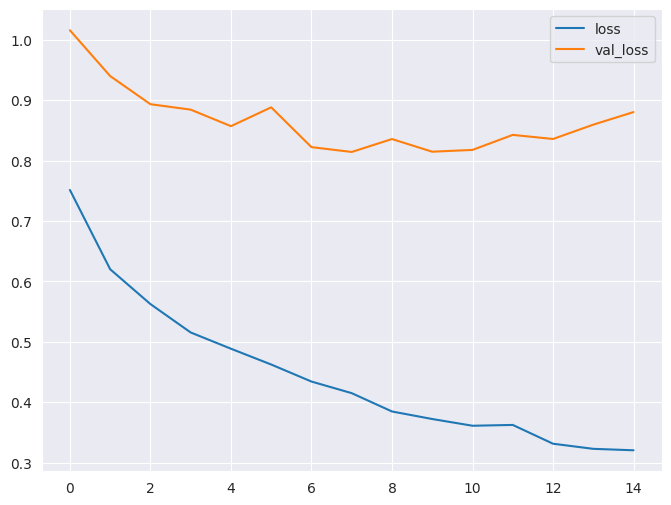

In [22]:
history = compile_and_fit(lstm_lags, window, MAX_EPOCHS=15, lr=1e-03)

print("==================================================")
train_val_performance['Conv1d'] = lstm_lags.evaluate(window.train_val, verbose=2)
val_performance['Conv1d'] = lstm_lags.evaluate(window.val, verbose=2)
test_performance['Conv1d'] = lstm_lags.evaluate(window.test, verbose=2)

# plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()